# Percona XtraDB Cluster 8.0 in IO bound workload and multiple writers
Percona XtraDB Cluster 8.0 is on the final stretch before GA release, and we have pre-release packages available for testing: https://www.percona.com/blog/2020/03/19/help-drive-the-future-of-percona-xtradb-cluster/

I want to see how Percona XtraDB Cluster 8.0 performs in IO-bound scenarios with multiple writers , like in my previous posts about MySQL Group Replication:
https://docs.google.com/document/d/1vHYl8GaMnYeXsJWvg_k9FH1NmznxH9N4vY8HOcubfa4/edit#

In this blog I want to evaluate Percona XtraDB Cluster 8.0 Scaling capabilities in both cases when we increase the amount of nodes and increase user connections. The version I used is Percona-XtraDB-Cluster-8.0.18 available from https://www.percona.com/downloads/Percona-XtraDB-Cluster-80/Percona-XtraDB-Cluster-8.0.18-9.1.rc/binary/tarball/Percona-XtraDB-Cluster_8.0.18.9_Linux.x86_64.bionic.tar.gz

For this testing I deploy multi node bare metal servers, where each node and client are dedicated to an individual server and connected between themselves by 10Gb network

Also I will use 3-nodes and 5-nodes Percona XtraDB Cluster setup.

<img src="https://raw.githubusercontent.com/Percona-Lab-results/PXC-8-March2020/master/img/schema.png" /> 

Hardware specifications:

```
System | Supermicro; SYS-F619P2-RTN; v0123456789 (Other)
   Platform | Linux
    Release | Ubuntu 18.04.4 LTS (bionic)
     Kernel | 5.3.0-42-generic
Architecture | CPU = 64-bit, OS = 64-bit
  Threading | NPTL 2.27
    SELinux | No SELinux detected
Virtualized | No virtualization detected
# Processor ##################################################
 Processors | physical = 2, cores = 40, virtual = 80, hyperthreading = yes
     Models | 80xIntel(R) Xeon(R) Gold 6230 CPU @ 2.10GHz
     Caches | 80x28160 KB
# Memory #####################################################
      Total | 187.6G
```

For the benchmark I use sysbench-tpcc 1000W, prepared database as

```
./tpcc.lua --mysql-host=172.16.0.11,172.16.0.12 --mysql-user=sbtest --mysql-password=sbtest --mysql-db=sbtest --time=300 --threads=64 --report-interval=1 --tables=10 --scale=100 --db-driver=mysql --use_fk=0 --force_pk=1 --trx_level=RC prepare
```

The configs, scripts and raw results are available on our github: https://github.com/Percona-Lab-results/PXC-8-March2020

Workload is “IO bound”, that is data (about 100GB) does not fit into innodb_buffer_pool (25GB) and there are intensive read/write IO operations


In [10]:
library(IRdisplay)

display_html(
'<script>  
code_show=false; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [11]:
library (RCurl)
library(ggplot2)
library(repr)

In [15]:
loadd  <- function (writers,nodes) {
    threads <- c(1,2,4,8,16,64,128,256)
    res = data.frame()
    for (val in threads) {
        #res-tpcc-PXC8-5nodes-2writer-BP25G-1
        urldown=paste0("https://raw.githubusercontent.com/Percona-Lab-results/PXC-8-March2020/master/res-tpcc-PXC8-",nodes,"nodes-",writers,"writer-BP25G-1","/res_thr",val,".txt")
        download <- getURL(urldown)
        
        dl<-strsplit(download, split='\n')
        data <- read.csv (text = grep("^[0-9]", dl[[1]], value = TRUE), header=F)
        
        data$threads=val
        data$nodes=nodes
        data$writers=writers
        if(nrow(res)<1){
            res<-data
        }else{
            res<-rbind(data,res)
        }
    }
    
    return(res)
}



In [16]:
r1 <- loadd("1","3")
r2 <- loadd("2","3")
r3 <- loadd("3","3")
r4 <- loadd("1","5")
r5 <- loadd("2","5")
r6 <- loadd("3","5")
results<-rbind(r1,r2,r3,r4,r5,r6)

In [17]:
theme_set(theme_light())
theme_replace(axis.text.x=element_text(size = rel(2)))
theme_replace(axis.text.y=element_text(size = rel(2)))
theme_replace(axis.title.x=element_text(size = rel(1.5)))
theme_replace(axis.title.y=element_text(size = rel(1.5), angle = 90))
theme_replace(legend.title=element_text(size = rel(1.5)))
theme_replace(legend.text=element_text(size = rel(1.5)))
theme_replace(plot.title=element_text(size = rel(2)))
theme_replace(strip.text.x=element_text(size = rel(2)))
theme_replace(strip.text.y=element_text(size = rel(2)))



## Results
Let’s review the results I’ve got.

### 3 nodes
First, let’s take a look at how performance changes when we increase user threads from 1 to 256 for 3 nodes.


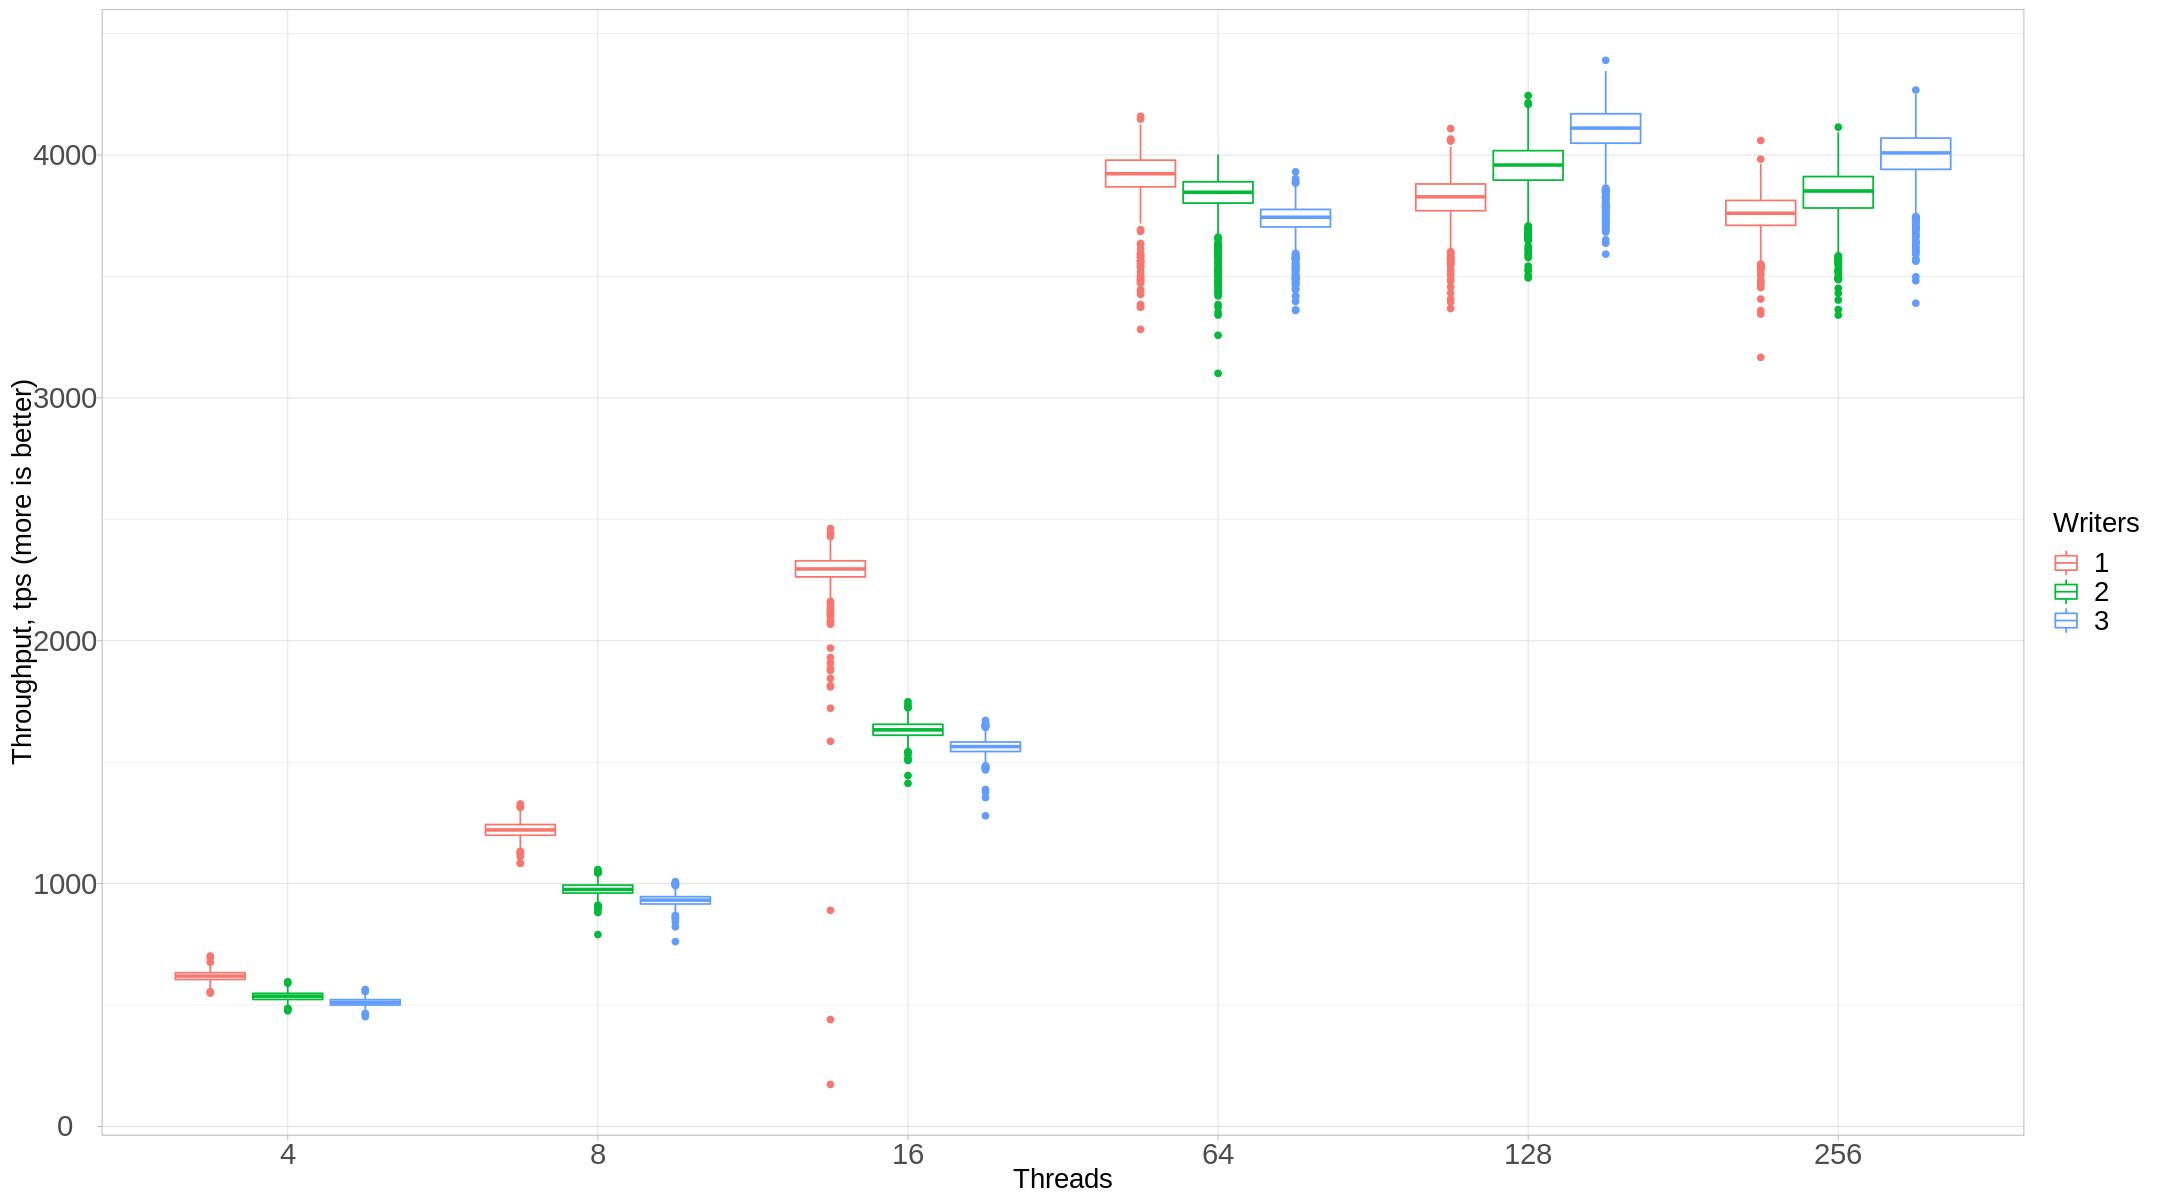

In [22]:
m <- ggplot(data = subset(results,V1>900 & nodes==3 & threads>2), 
            aes(x=as.factor(threads), y=V3, color=as.factor(writers)))

options(repr.plot.width=18, repr.plot.height=10)


m + geom_boxplot()+
    ylab("Throughput, tps (more is better)")+
    xlab("Threads")+
    scale_colour_discrete(name="Writers")

### Percona XtraDB Cluster 3 nodes - Individual scales
To see the density of the results it in more details, let’s draw the chart with the individual scales for each set of threads:

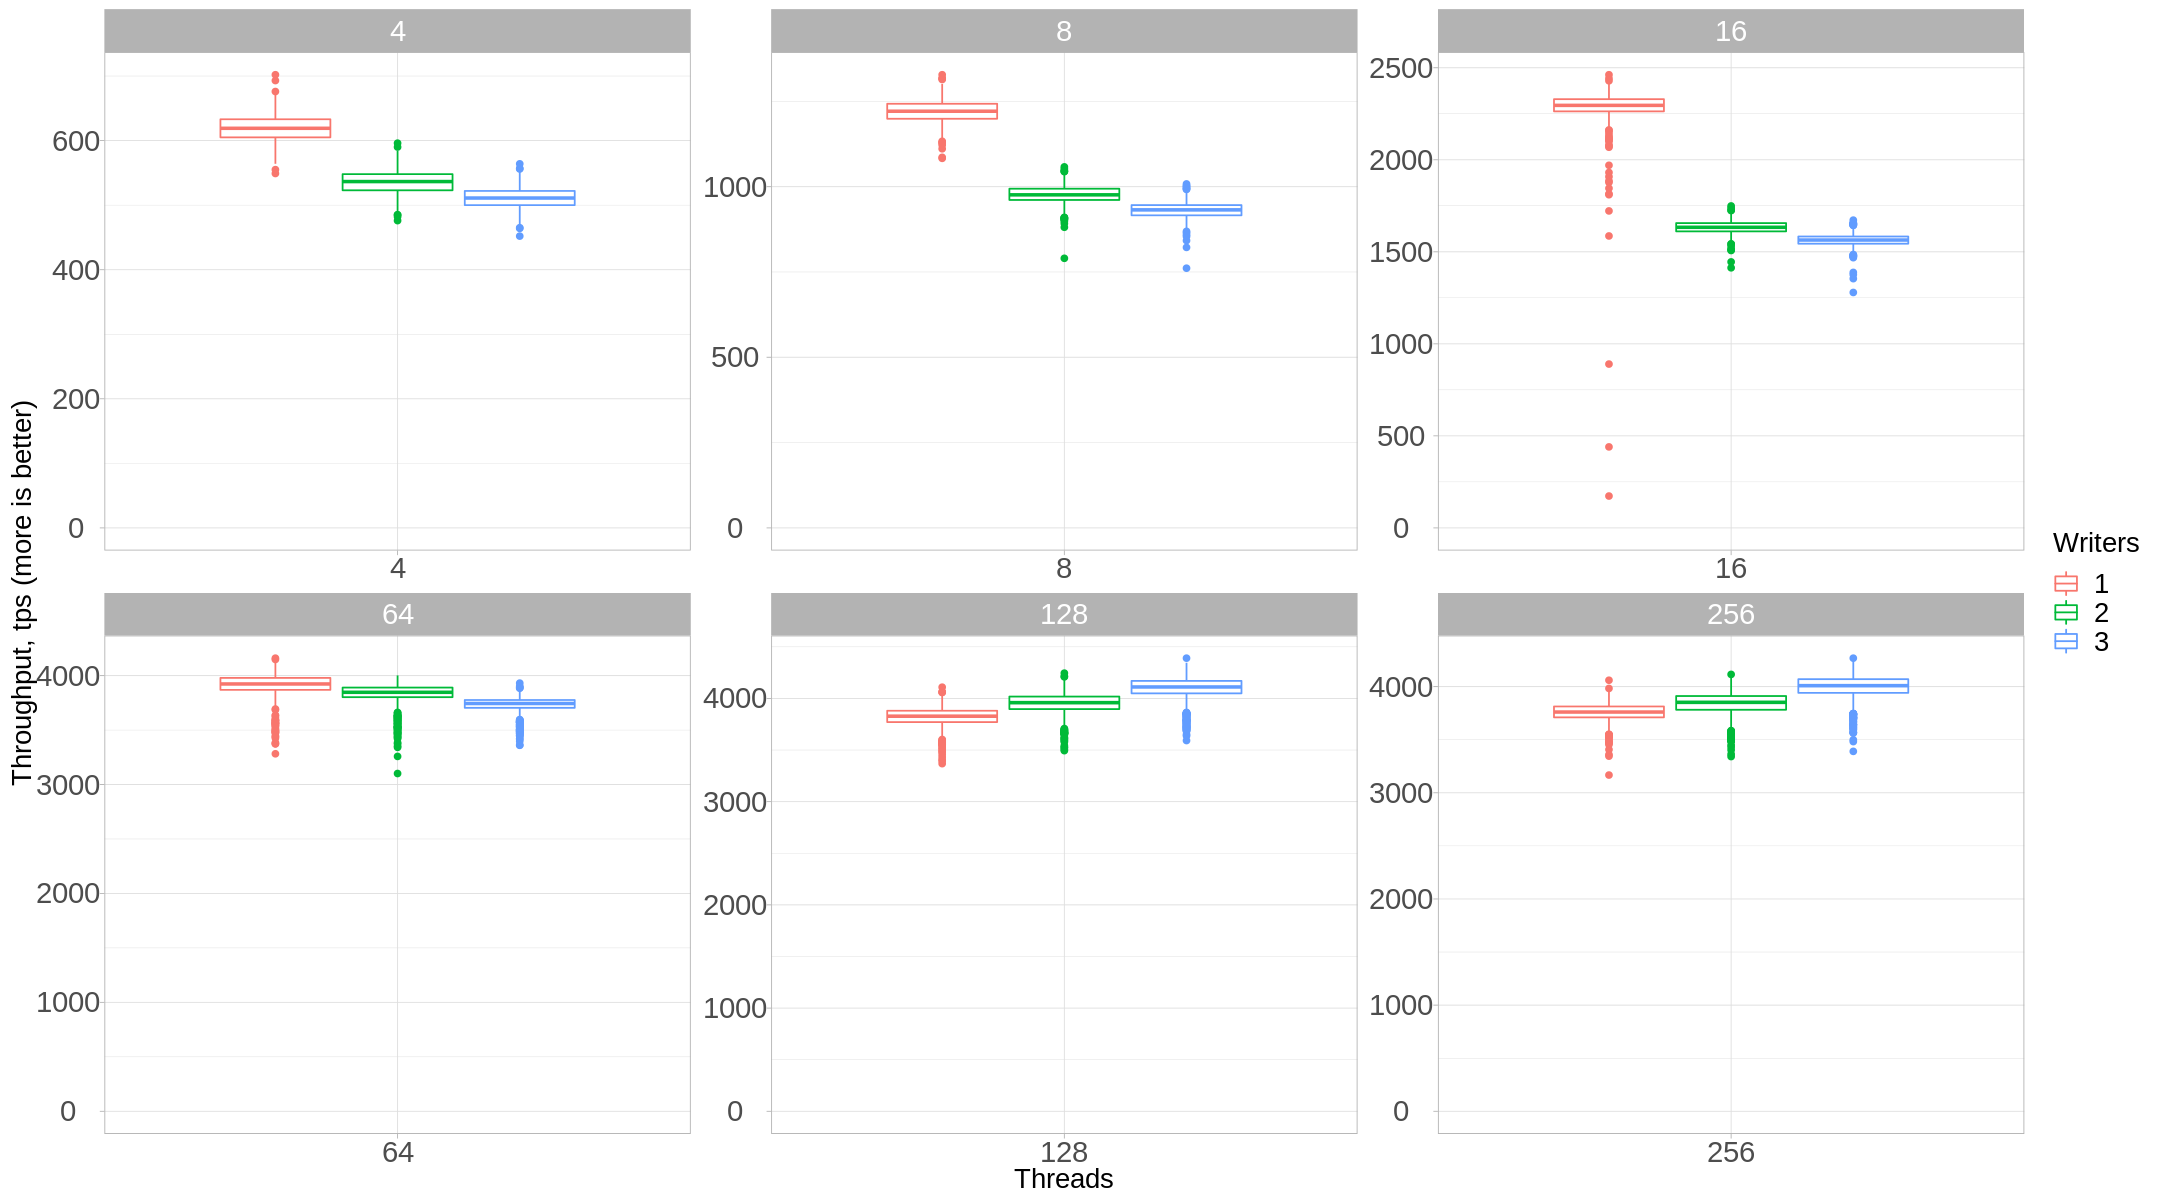

In [23]:
m <- ggplot(data = subset(results, V1>900 & nodes==3& threads>2), 
            aes(x=as.factor(threads), y=V3, color=as.factor(writers)))

options(repr.plot.width=18, repr.plot.height=10)


m + geom_boxplot()+
    ylab("Throughput, tps (more is better)")+
    xlab("Threads")+
    scale_colour_discrete(name="Writers")+facet_wrap( ~ threads,scales="free")+expand_limits(y=0)

### Percona XtraDB Cluster 3 nodes, timeline for 64 threads

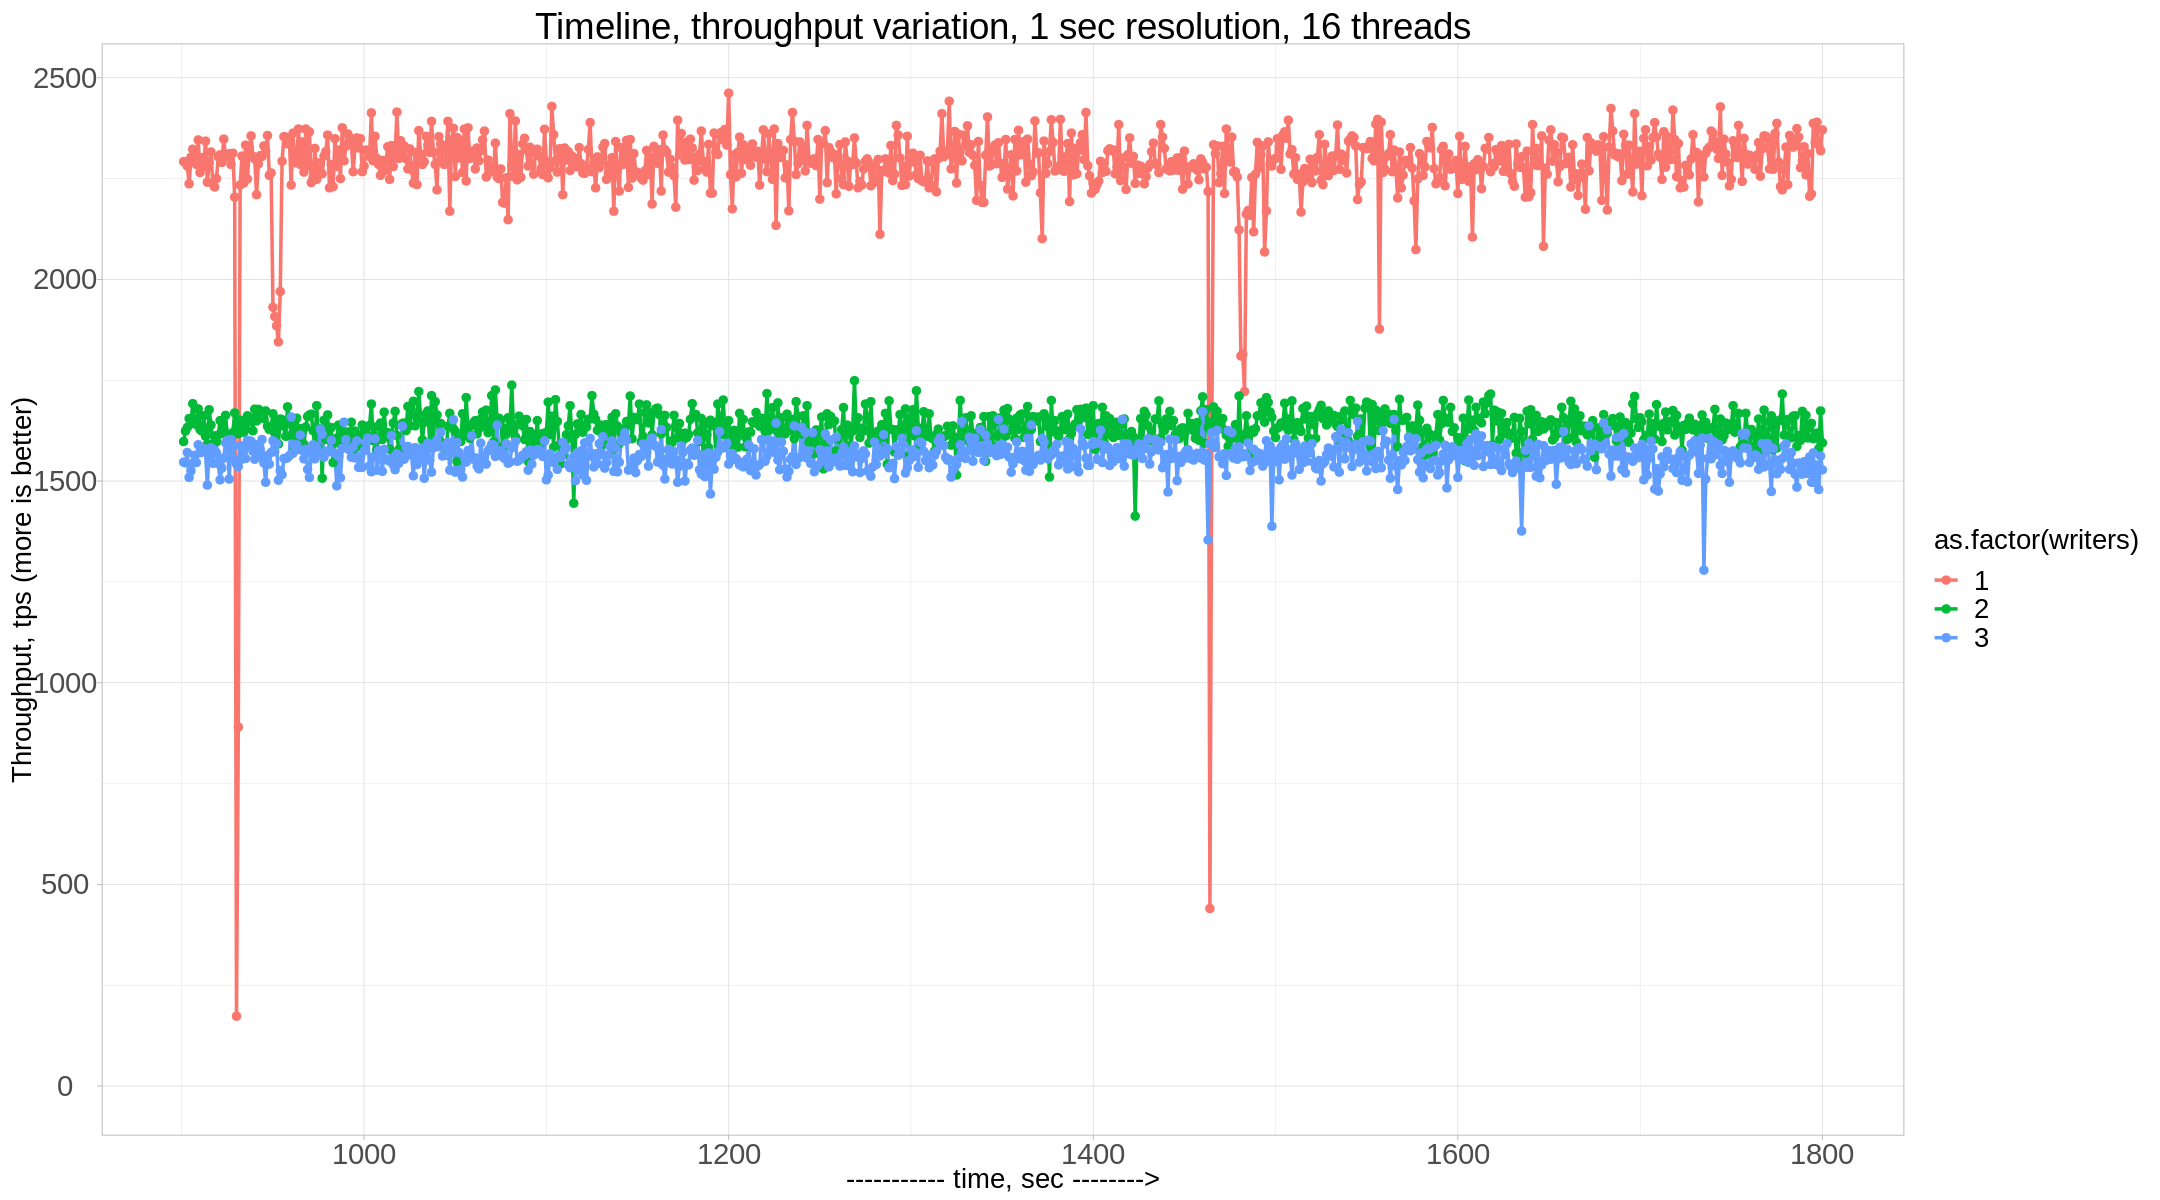

In [26]:
m <- ggplot(data = subset(results, V1>900 & nodes==3 & threads==16), 
            aes(x=V1, y=V3,color=as.factor(writers)))

options(repr.plot.width=18, repr.plot.height=10)


m + geom_line(size=1)+geom_point(size=2)+
    ylab("Throughput, tps (more is better)")+
    xlab("----------- time, sec -------->")+
    labs(title="Timeline, throughput variation, 1 sec resolution, 16 threads")+    
    expand_limits(y=0)

### 3 nodes vs 5 nodes

Now let’s the performance under 5 nodes (comparing to 3 nodes)


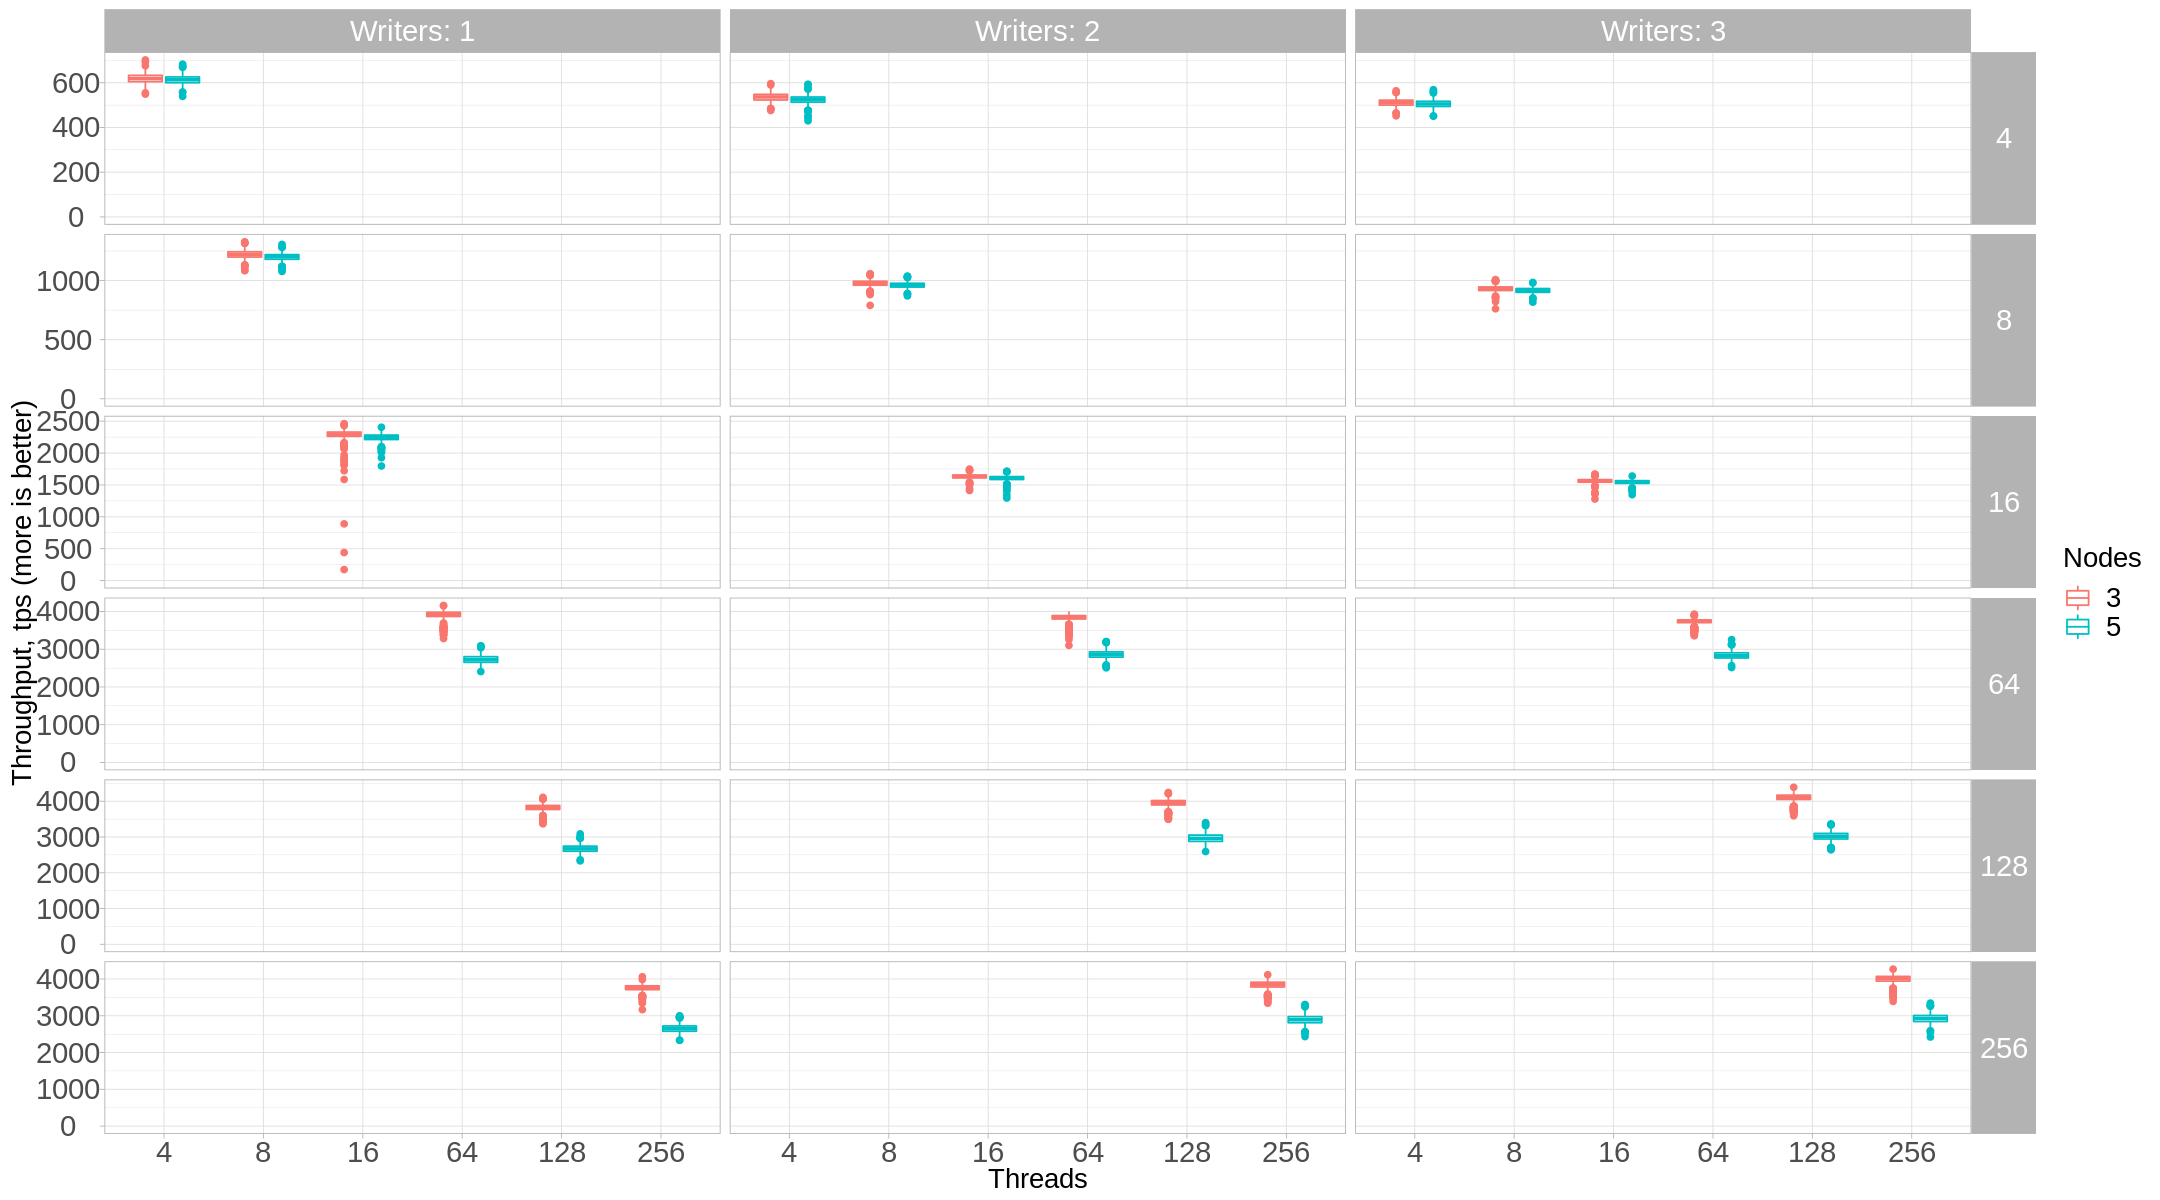

In [35]:
m <- ggplot(data = subset(results,V1>900  & threads>2 & writers>0), 
            aes(x=as.factor(threads), y=V3, color=as.factor(nodes)))

options(repr.plot.width=18, repr.plot.height=10)

writerslabel <- function(strings) {
    strings <- paste("Writers:", strings)
}


m + geom_boxplot()+
    ylab("Throughput, tps (more is better)")+
    xlab("Threads")+
    scale_colour_discrete(name="Nodes")+facet_grid( threads ~ writers ,scales="free",labeller=labeller(writers =writerslabel ))+expand_limits(y=0)


## Conclusion
Multiple writers add additional overhead, which is quite visible on low amount of threads. This is maybe contradictory to an opinion that Percona XtraDB Cluster and other Galera based solution can be used to scale write workloads. While Percona XtraDB Cluster shows resonable results under multiple writers workloads, this should be used only for convinience purpose, not for performance.